In [155]:
# Run this again after editing submodules so Colab uses the updated versions
from citylearn import CityLearn
from pathlib import Path
from agent_final import Agent
import numpy as np
import torch

import time
#agent 24 w/ action weight of 0.95, 0.05 + [5, 5, 1] for cost coeff.
# Load environment
sim_period = (0, 8759)
climate_zone = 5
params = {
    "data_path": Path("data/Climate_Zone_" + str(climate_zone)),
    "building_attributes": "building_attributes.json",
    "weather_file": "weather_data.csv",
    "solar_profile": "solar_generation_1kW.csv",
    "carbon_intensity": "carbon_intensity.csv",
    "building_ids": ["Building_" + str(i) for i in [1]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "simulation_period": (0, 8759 - 1),
    "cost_function": [
        "ramping",
        "1-load_factor",
        "average_daily_peak",
        "peak_demand",
        "net_electricity_consumption",
        "carbon_emissions",
    ],
    "central_agent": False,
    "save_memory": False,
}

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

params_agent = {
    "building_ids": ["Building_" + str(i) for i in [1]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "building_info": building_info,
    "observation_spaces": observations_spaces,
    "action_spaces": actions_spaces,
}

# Instantiating the control agent(s)
agents = Agent(**params_agent)

state = env.reset()
done = False

action, coordination_vars = agents.select_action(state)
start = time.time()
while not done:
    next_state, reward, done, _ = env.step(action)
    action_next, coordination_vars_next = agents.select_action(next_state)
    agents.add_to_buffer(
        state,
        action,
        reward,
        next_state,
        done,
        coordination_vars,
        coordination_vars_next,
    )
    coordination_vars = coordination_vars_next
    state = next_state
    action = action_next
    print(f"\r {env.time_step}", end="")

print(f"\ntotal time (min): {np.round((time.time() - start)/60, 3)}")

cost = env.cost(sim_period)

cost_details = env.cost_detailed_view()

 8758
total time (min): 1.27
Time taken to add RBC pretrained model (sec): 1.288


In [156]:
cost

({'ramping': 0.8606948,
  '1-load_factor': 0.9744182291533756,
  'average_daily_peak': 0.8213672,
  'peak_demand': 0.8966831,
  'net_electricity_consumption': 0.9596711,
  'carbon_emissions': 0.9606298,
  'total': 0.9122440428022909,
  'coordination_score': 0.8882908389694046},
 <citylearn.CityLearn at 0x7fe79cb63730>)

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

In [157]:
import matplotlib.pyplot as plt
import pandas as pd
results_RBC = pd.read_csv('milp/results_RBC.csv') 
results_RBC['method'] = ['RBC']*len(results_RBC)
sim_results_RBC = pd.read_csv('milp/sim_results_RBC.csv')
sim_results_RBC['method'] = ['RBC']*len(sim_results_RBC)
results_RBC['solar_gen'] = sim_results_RBC['solar_gen']
results = pd.read_csv('milp/results_r_1.csv') 
results['method'] = ['MILP_R_1']*len(results)
sim_results  = pd.read_csv('milp/sim_results_r_1.csv')
sim_results ['method'] = ['MILP_R_1']*len(sim_results )
results['solar_gen'] = sim_results['solar_gen']

In [158]:
len(results)

720

In [176]:
k = 700

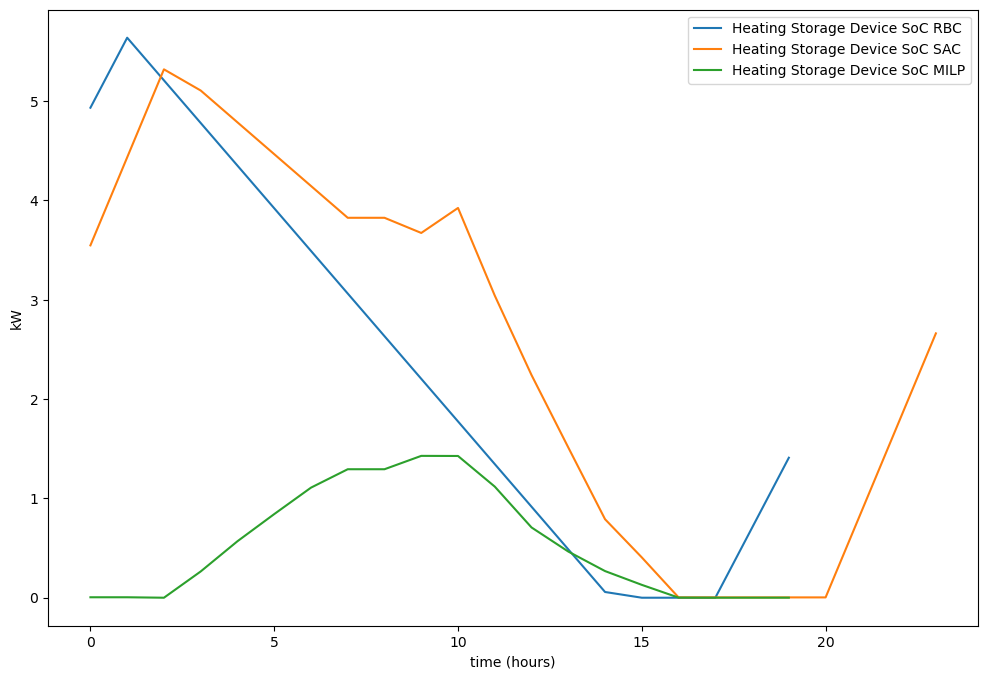

In [177]:
t1= k
t2 = k+24
building_number = 'Building_1'
interval = range(24-1)
plt.figure(figsize=(12,8))
plt.plot(list(results_RBC.dhw_storage_soc[t1:t2]))
plt.plot(env.buildings[building_number].dhw_storage_soc[t1:t2])
plt.plot(list(results.dhw_storage_soc[t1:t2]))
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend([
            'Heating Storage Device SoC RBC', 
     
            'Heating Storage Device SoC SAC', 

            'Heating Storage Device SoC MILP'])

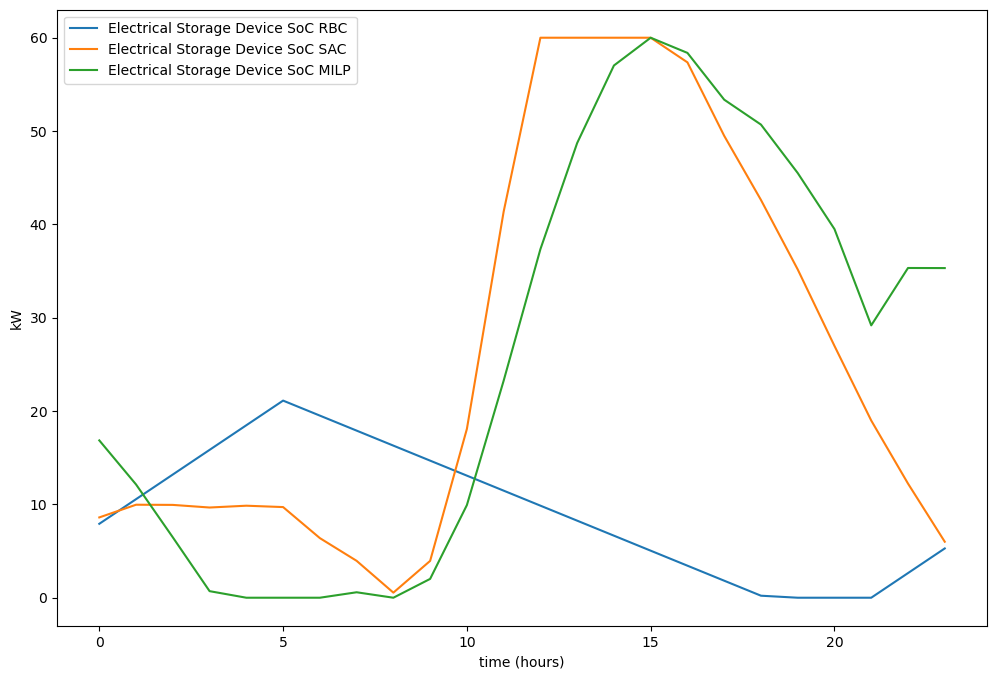

In [161]:
t1= 720-24*5
t2 = 720-24*4
building_number = 'Building_1'
interval = range(24-1)
plt.figure(figsize=(12,8))
plt.plot(list(results_RBC.electrical_storage_soc[t1:t2]))
plt.plot(env.buildings[building_number].electrical_storage_soc[t1:t2])
plt.plot(list(results.electrical_storage_soc[t1:t2]))
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend([
            'Electrical Storage Device SoC RBC',

            'Electrical Storage Device SoC SAC',
 
            'Electrical Storage Device SoC MILP'])

In [48]:
list(results_RBC.electrical_storage_soc[t1:t2])

[7.92,
 10.56,
 13.2,
 15.840000000000002,
 18.48,
 21.12,
 19.512,
 17.904,
 16.296,
 14.688,
 13.079999999999998,
 11.471999999999998,
 9.863999999999995,
 8.255999999999997,
 6.647999999999996,
 5.039999999999996,
 3.431999999999995,
 1.8239999999999947,
 0.2159999999999944,
 0.0,
 0.0,
 0.0,
 2.64,
 5.28]

In [49]:
env.buildings[building_number].electrical_storage_soc[t1:t2]

array([13.24337171, 18.38832549, 24.87952768, 32.51695969, 37.87057586,
       45.53214636, 54.57915907, 59.47335483, 35.07417105, 28.89342915,
       36.77737039, 40.17590234, 48.1132737 , 50.70741551, 54.2466986 ,
       53.04669863, 38.81393889, 16.60745518, 13.96719598, 12.52687967,
       11.08642098,  8.79985567,  6.94555447,  6.00006948])

In [51]:
list(results.electrical_storage_soc[t1:t2])

[0.0003351712171632,
 0.0007491231921755,
 0.0005673525424403,
 0.0005783012240008,
 0.0006955663460972,
 0.0006733561310975,
 0.0007486495013519,
 0.0007439117152335,
 0.4845680546226653,
 60.0,
 46.767132788875074,
 30.903678012284697,
 18.35763227973428,
 2.757994085755655,
 0.0001122514529434,
 7.56703276349625e-05,
 1.3150716702155623e-06,
 3.108386560241545e-06,
 7.170620121579646e-07,
 1.787704801285376e-06,
 5.24677325655878e-10,
 0.0005030562356042,
 0.0001769181448885,
 0.0001008109597147]

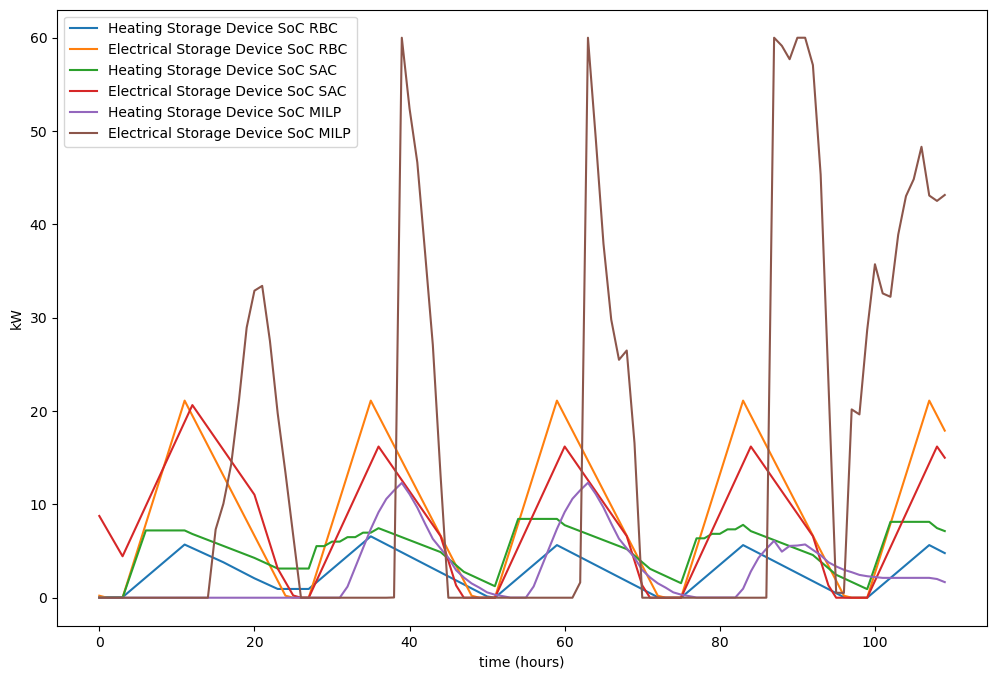

In [36]:
t1= 90
t2 = 200
building_number = 'Building_1'
interval = range(24-1)
plt.figure(figsize=(12,8))
plt.plot(list(results_RBC.dhw_storage_soc[t1:t2]))
plt.plot(list(results_RBC.electrical_storage_soc[t1:t2]))
plt.plot(env.buildings[building_number].dhw_storage_soc[t1:t2])
plt.plot(env.buildings[building_number].electrical_storage_soc[t1:t2])
plt.plot(list(results.dhw_storage_soc[t1:t2]))
plt.plot(list(results.electrical_storage_soc[t1:t2]))
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend([
            'Heating Storage Device SoC RBC', 
            'Electrical Storage Device SoC RBC',
            'Heating Storage Device SoC SAC', 
            'Electrical Storage Device SoC SAC',
            'Heating Storage Device SoC MILP', 
            'Electrical Storage Device SoC MILP'])

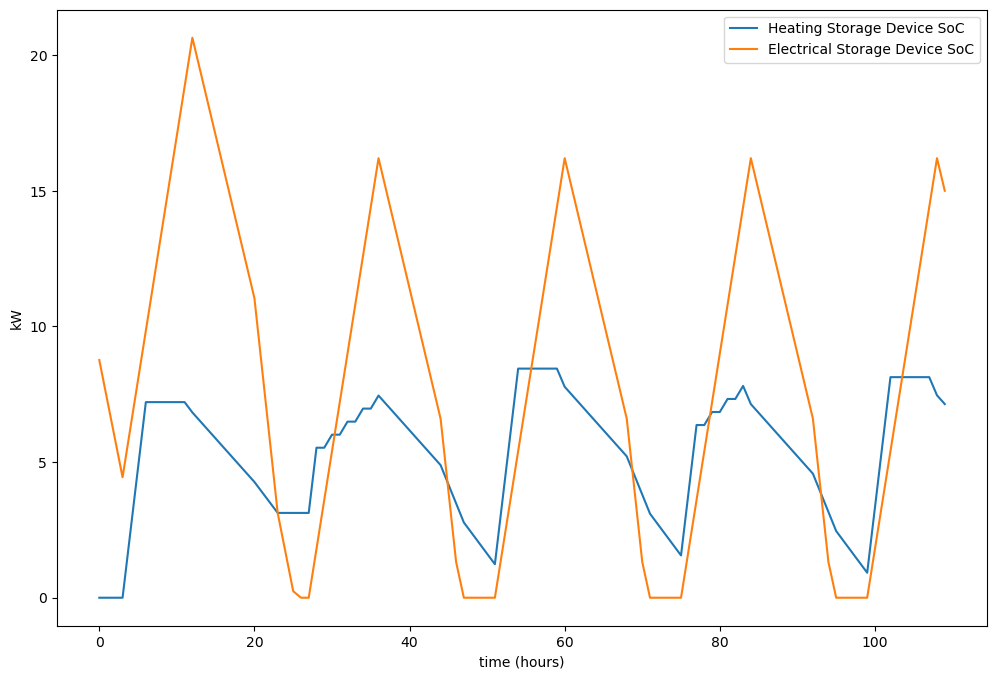

In [17]:
t1= 90
t2 = 200
building_number = 'Building_1'
interval = range(24-1)
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].dhw_storage_soc[t1:t2])
plt.plot(env.buildings[building_number].electrical_storage_soc[t1:t2])
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend([
            'Heating Storage Device SoC', 
            'Electrical Storage Device SoC'])

In [11]:
print("Building ID\tTotal Cost\tTotal Cost Last Year")
for k, v in cost_details.items():
    print(k, v["cost"]["total"], v["cost_last_year"]["total_last_yr"])

Building ID	Total Cost	Total Cost Last Year
Building_1 0.9838074766302695 0.9854307655230203
